In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [4]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [46]:
it = 1 # read in it (independent process)

In [28]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74

In [29]:
with open(os.path.join(working, 'stats_clean'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_clean'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [30]:
multi_index = []
multi_index.append([0, 3, 5, 8, 13, 17, 20, 24, 27, 31])
multi_index.append([2, 4, 8, 11, 13, 17, 20, 24, 27, 32])
multi_index.append([1, 4, 6, 9, 13, 17, 20, 24, 27, 31])
multi_index.append([1, 4, 7, 9, 13, 17, 20, 24, 27, 31])
multi_index.append([1, 3, 5, 8, 12, 16, 19, 23, 28, 31])
multi_index.append([0, 4, 6, 8, 12, 17, 20, 25, 28, 32])

In [31]:
stats_opts = []
for index in multi_index:
    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
    print(np.array(stats_ready['hyperparams'])[index])
    stats_opts.append(select_nodes(stats_ready, index))

[2.4  2.65 2.72 2.75 3.   3.45 4.   4.5  5.   5.6 ]
[2.5  2.7  2.75 2.85 3.   3.45 4.   4.5  5.   5.75]
[2.45 2.7  2.73 2.77 3.   3.45 4.   4.5  5.   5.6 ]
[2.45 2.7  2.74 2.77 3.   3.45 4.   4.5  5.   5.6 ]
[2.45  2.65  2.72  2.75  2.9   3.3   3.75  4.356 5.15  5.6  ]
[2.4  2.7  2.73 2.75 2.9  3.45 4.   4.65 5.15 5.75]


In [32]:
#pars_dict['pair'] = [-28.301652628205268, -0.0022071786576090694, 0.027656591839734557, -6.543090393280296, 10.102407371395133, -2.478121982724172, 3.7048200337887582, -3.6346043391919514, 1.7181534576100437, -0.2520201994640249]
#pars_dict['embed'] = [-1.1825596913794016, 2.8944059727957714e-05]
pars_list = []
for index in multi_index:
    pars_dict = {}
    if len(np.array(stats_ready['hyperparams'])[index]) == 10:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 0.0, 2.30194161e+01, 0.0, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]
    elif len(np.array(stats_ready['hyperparams'])[index]) == 9:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 0.0, 2.30194161e+01, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]        
    elif len(np.array(stats_ready['hyperparams'])[index]) == 8:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 2.30194161e+01, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]        
    else:
        raise ValueError('Unsupported number of parameters')
    print(len(np.array(stats_ready['hyperparams'])[index]), len(pars_dict['pair']))
    pars_list.append(pars_dict)

with open(os.path.join(working, "pars_in.pickle"), 'wb') as fo:
    pickle.dump(pars_list, fo)


10 10
10 10
10 10
10 10
10 10
10 10


In [33]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_list = pickle.load(fi)
print(pars_list)

[{'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}]


In [47]:
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [48]:
pars_dict = pars_list[it]
pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in, len(pars_in))

[-0.684229349, 0.000152487644, -65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974] 12


In [36]:
target[0]['weight'] = 1.0
target[1]['weight'] = 2.0
target[2]['weight'] = 0.5
target[3]['weight'] = 1.0
target[4]['weight'] = 0.8

In [37]:
len(target[0]['energy']), [t['weight'] for t in target], target[1]['energy']

(1284,
 [1.0, 2.0, 0.5, 1.0, 0.8],
 [-1139.2,
  -906.9778906249999,
  -1127.13044453125,
  -1136.3561554687499,
  -1136.7059554687498,
  0.0,
  0.0])

In [38]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=3):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
    #print(optimal_parameters)
                 
    best_params = sorted(optimal_parameters, key=lambda param: param[0])[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [ ]:
multi_pars = []

multi_pars.append(pars_in)

multi_pars.append([-1.48107607e+00, -2.11281591e-06, -7.75748552e+01,  1.23284902e+02,
       -1.05876828e+02,  2.56371829e+01,  7.21885424e-01, -2.01549825e+00,
        9.46930507e-01,  2.72867578e-01, -1.23624777e+00,  4.90853203e-01])

multi_pars.append([ 4.21813176e+00,  1.28438711e-02,  7.18447209e+02,  2.79873504e+01,
       -3.64063120e+01,  1.55668343e+01, -3.59671207e+00,  7.18079901e-02,
       -7.56657066e-02,  2.53180527e-01, -4.96952030e-01, -4.27379804e-02])

multi_pars.append([-1.70284536e+00,  1.77584742e-03, -2.03091714e+02,  6.67172987e+02,
       -1.39072153e+03,  7.95275451e+02, -2.44611978e+01,  5.09001525e+00,
       -3.57713253e-01, -1.04584266e+00,  1.30255105e+00, -4.09472026e-01])

multi_pars.append([ 1.49705729e+00,  8.14531512e-03, -8.15988329e+02,  5.87519886e+02,
       -1.01285873e+03,  5.10026120e+02, -1.11686150e+01,  1.51343754e+00,
        1.15612472e-01, -4.84858749e-01,  3.56870076e-01, -2.09915075e-01])

multi_pars.append([ 1.54864560e+00,  1.06062750e-02, -3.00996729e+02,  3.32437763e+02,
       -3.39714171e+02,  9.93126859e+01, -2.04873166e+01,  1.12932344e+00,
       -7.73962738e-02, -1.97622239e-01,  1.14699068e-01, -1.23093792e-01])

multi_pars.append([ 1.08153442e+00,  2.12340093e-03, -2.83828424e+02,  3.30196594e+02,
       -3.61260411e+02,  1.30278313e+02, -3.12845720e+01,  2.97822976e+00,
       -5.85372576e-02, -8.72679252e-01,  5.95310242e-01, -2.30722232e-01])

multi_pars.append([-1.84530425e+00, -2.18389467e-05, -1.46520729e+03,  1.16790147e+02,
       -1.41528209e+02,  7.82448301e+01,  4.04340173e+00, -2.96638562e+00,
        2.19448488e+00, -5.43928853e-01, -1.31154657e+00,  7.46848321e-01])


In [ ]:
for ieam in range(6, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    m_pars = multi_pars
    for i in range(6):
        best_pars = optimize_EAM(target, stats, ieam, m_pars, n_b=len(m_pars))
        m_pars = [p[1] for p in best_pars]

ieam: 6
0  sd2: ini 4.566322961003563sd2: final 0.031512011969636426
1  sd2: ini 6.495497546660811sd2: final 0.04664846152059008
2  sd2: ini 0.27555472641168044sd2: final 0.004902658966823722
3  sd2: ini 3.1923806920526197sd2: final 0.022247256844495356
4  sd2: ini 2.1937723838210976sd2: final 0.013497727103121224
5  sd2: ini 0.009081411815950284sd2: final 0.00495957988277652
6  sd2: ini 4.234915514541553sd2: final 0.005016189558421776
7  sd2: ini 7.166774592828621sd2: final 0.07167392008199118
Best params: [(0.004902658966823722, array([ 2.59960407e+00,  1.40021448e-02, -1.38932046e+02,  1.21023410e+02,
       -1.18044655e+02,  3.15558604e+01, -1.04641599e+01,  3.07602172e-01,
       -6.60545492e-01,  5.15590058e-01, -3.49930236e-01, -6.33063669e-02])), (0.00495957988277652, array([ 2.77761091e+00,  1.46576680e-02, -2.27671675e+02,  2.11860479e+02,
       -2.05575146e+02,  5.07507902e+01, -1.18347289e+01, -6.57147730e-02,
       -6.49693925e-01,  6.20087855e-01, -4.39985843e-01, -5.01

0  sd2: ini 0.004639595573920368sd2: final 0.004639595573920272
1  sd2: ini 0.004639595573920851sd2: final 0.004639595573920432
2  sd2: ini 0.004639595573926451sd2: final 0.004639595573925191
3  sd2: ini 0.004639618086683249sd2: final 0.004639614166134912
4  sd2: ini 0.004642794733067175sd2: final 0.004639604481235682
5  sd2: ini 0.004646073343219618sd2: final 0.004641903427244805
6  sd2: ini 0.004665686101583599sd2: final 0.0046576029212362
7  sd2: ini 0.00467059378523735sd2: final 0.004639789883060681
Best params: [(0.004639595573920272, array([ 2.61411686e+00,  1.44689461e-02, -1.90339171e+02,  1.60713127e+02,
       -1.50065201e+02,  3.41733929e+01, -9.38215096e+00, -2.75667517e-01,
       -3.45258425e-01,  3.18322256e-01, -2.84002515e-01, -6.97804133e-02])), (0.004639595573920432, array([ 2.61411702e+00,  1.44689470e-02, -1.90339201e+02,  1.60713188e+02,
       -1.50065263e+02,  3.41734074e+01, -9.38215274e+00, -2.75667624e-01,
       -3.45258680e-01,  3.18322570e-01, -2.84002690e

0  sd2: ini 0.013070764515618803sd2: final 0.012959028335556004
1  sd2: ini 0.013245623621704939sd2: final 0.012955325815096175
2  sd2: ini 0.01342532660350049sd2: final 0.012953767988984097
3  sd2: ini 0.013547025396611009sd2: final 0.0129577791986159
4  sd2: ini 0.013830141385309979sd2: final 0.013207980514940328
5  sd2: ini 0.013989355592374936sd2: final 0.013030821790785518
6  sd2: ini 0.015356615618401242sd2: final 0.013066753625332876
7  sd2: ini 0.020569765462237176sd2: final 0.015625931326164317
Best params: [(0.012953767988984097, array([ 2.30502252e+00,  3.07508443e-03, -2.41877376e+02,  2.21829939e+02,
       -2.34314191e+02,  8.22606879e+01, -2.27797151e+01,  2.08081662e+00,
       -2.29840932e-01, -5.74039931e-01,  3.65024937e-01, -2.49802389e-01])), (0.012955325815096175, array([ 2.27810564e+00,  3.05681617e-03, -2.42083311e+02,  2.22881863e+02,
       -2.35739393e+02,  8.29328506e+01, -2.29143652e+01,  2.11703830e+00,
       -2.56249171e-01, -5.55369078e-01,  3.59899808e

0  sd2: ini 4.480128259620955sd2: final 0.015764590392455813
1  sd2: ini 5.734007959620898sd2: final 0.01783684199863498
2  sd2: ini 7.229663523301369sd2: final 0.015985594802362516
3  sd2: ini 4.546694670519672sd2: final 0.3175819475348936
4  sd2: ini 7.1693172190475005sd2: final 0.12722017807266756
5  sd2: ini 7.211462331684125sd2: final 0.015781717914616005
6  sd2: ini 6.648628655270479sd2: final 0.019746648546300354
7  sd2: ini 6.987223389112881sd2: final 0.020266452105984323
Best params: [(0.015764590392455813, array([-2.41918402e+00,  5.70999284e-05, -5.08139534e+01,  6.82343146e-03,
        1.97524649e+01,  8.66191430e-03, -2.76772005e+00,  4.69464460e-01,
        3.94410929e-01, -9.73107437e-01,  2.57756767e-01,  1.41688026e-01])), (0.015781717914616005, array([-1.65225720e+00,  2.93064540e-05, -2.84810249e+02,  2.65237727e+02,
       -2.59117609e+02,  8.51649552e+01, -1.74700271e+01,  2.45492987e+00,
       -7.04838433e-02, -6.90334225e-01,  3.06233176e-01,  4.13242409e-02])),

0  sd2: ini 0.013333742325057303sd2: final 0.013333742325057303
1  sd2: ini 0.013333742325058708sd2: final 0.013333742325058708
2  sd2: ini 0.013333742325062767sd2: final 0.013333742325062767
3  sd2: ini 0.013333759063332212sd2: final 0.013333752136345117
4  sd2: ini 0.013334164391863152sd2: final 0.013333830906425898
5  sd2: ini 0.013441806681314599sd2: final 0.013333742325056522
6  sd2: ini 0.013955713628443034sd2: final 0.01352984386275
7  sd2: ini 0.014045494653406716sd2: final 0.013375203392456344
Best params: [(0.013333742325056522, array([-3.32540396e+00, -2.48985648e-04, -4.52020127e+01,  9.78203287e+01,
       -9.17239110e+01,  3.38657644e+01, -4.17524825e+00,  3.01200213e-01,
        5.31933081e-01, -8.01673623e-01,  5.65231216e-02,  2.71304220e-01])), (0.013333742325057303, array([-3.32540374e+00, -2.48985477e-04, -4.52020078e+01,  9.78203430e+01,
       -9.17239278e+01,  3.38657670e+01, -4.17524964e+00,  3.01199758e-01,
        5.31933338e-01, -8.01673998e-01,  5.65232946e-

../../statmechlib/statmechlib/forcefields/eam.py:226: RuntimeWarning: overflow encountered in exp
  eee = np.exp(-uuu)


sd2: final 12.268686118726542
3  sd2: ini 7.070137846263654sd2: final 0.19890564222409463
4  sd2: ini 12.268686118726542sd2: final 12.268686118726542
5  sd2: ini 12.268686118726542sd2: final 12.268686118726542
6  sd2: ini 7.229627474974159sd2: final 0.025698328725541595
7  sd2: ini 6.145767783254056sd2: final 0.008456119415979294
Best params: [(0.0073725203821226205, array([-1.47043600e+00, -1.42796919e-06, -7.86921796e+01,  1.23530768e+02,
       -1.06108215e+02,  2.57089682e+01,  6.44893693e-01, -1.99658522e+00,
        9.48570359e-01,  2.57545515e-01, -1.22036910e+00,  4.85596704e-01])), (0.008456119415979294, array([-1.79249003e+00, -2.00331122e-05, -3.35312820e+01,  6.03345792e+01,
       -2.43444547e+01, -7.74532973e+00,  9.50962099e+00, -3.47822265e+00,
        1.68154006e+00,  7.65107568e-02, -1.43879186e+00,  6.14226236e-01])), (0.013028295363636418, array([-6.32023479e-01,  7.85959473e-05,  7.21522639e+01,  4.44563820e-02,
       -4.32910412e+00, -3.24850190e-02,  1.21800602e

In [ ]:
optimal_parameters = [(4.407570269501649e-05, [-1.21658318e+00,  3.24863580e-05, -4.73661687e+01,  2.29965951e+01,
       -3.42248343e+00,  3.73956980e+00, -1.39292737e+00, -8.33458565e-01,
        9.29769431e-01, -1.83568989e-01]), (6.17447812420396e-05, [-1.30551487e+00,  1.41920657e-05, -4.61160967e+01,  2.29352328e+01,
       -3.42360958e+00,  3.82313395e+00, -1.54715703e+00, -6.97925842e-01,
        8.68730239e-01, -1.54592379e-01]), (9.723561709685708e-05, [-1.34624502e+00,  7.49457487e-06, -4.58871674e+01,  2.24064873e+01,
       -3.46516902e+00,  4.02263760e+00, -1.89661680e+00, -4.31617423e-01,
        8.06406324e-01, -1.37562101e-01]), (0.00014123622250142564, [-1.34136558e+00,  1.01769934e-05, -4.93998032e+01,  2.21279115e+01,
       -3.50791272e+00,  4.16822104e+00, -2.13414308e+00, -2.66237999e-01,
        7.83819577e-01, -1.36703203e-01])]

In [24]:
ieam6 = (0.004639595573920272, np.array([ 2.61411686e+00,  1.44689461e-02, -1.90339171e+02,  1.60713127e+02,
       -1.50065201e+02,  3.41733929e+01, -9.38215096e+00, -2.75667517e-01,
       -3.45258425e-01,  3.18322256e-01, -2.84002515e-01, -6.97804133e-02]))

In [26]:
ieam9 = (0.008696488352891394, np.array([-1.47456565e+00, -4.79869485e-07, -1.68796012e+02,  1.01838014e+02,
       -1.89387663e+02,  1.23197119e+02,  1.67559787e+00, -1.97672693e+00,
        1.48460087e+00, -3.21160959e-01, -9.99990134e-01,  5.45243666e-01]))

In [49]:
ieam6 = (0.012529698209073237, np.array([ 1.77179483e+00,  1.05192096e-02, -2.93005591e+02,  3.18328136e+02,
       -3.22036226e+02,  9.25544422e+01, -1.89150669e+01,  9.60458059e-01,
        9.09101177e-02, -2.93381125e-01,  1.16059169e-01, -1.21580547e-01]))

In [58]:
ieam9 = (0.011166762673644966, np.array([-1.43897524e+00,  3.68357996e-06, -4.10835857e+01,  1.01633094e+02,
       -9.73045925e+01,  3.38437384e+01, -3.58251075e+00, -1.67919252e+00,
        8.65702805e-01,  2.65888291e-01, -1.20777286e+00,  4.75855652e-01]))

In [59]:
optimal_parameters = [ieam9]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1136.489148910112, -909.4128871306052, -1131.6136302133732, -1135.624918243269, -1135.5698294025856]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
Model: [-1136.489148910112, -909.4128871306052, -1131.6136302133732, -1135.624918243269, -1135.5698294025856]
0 0.011166762673644966


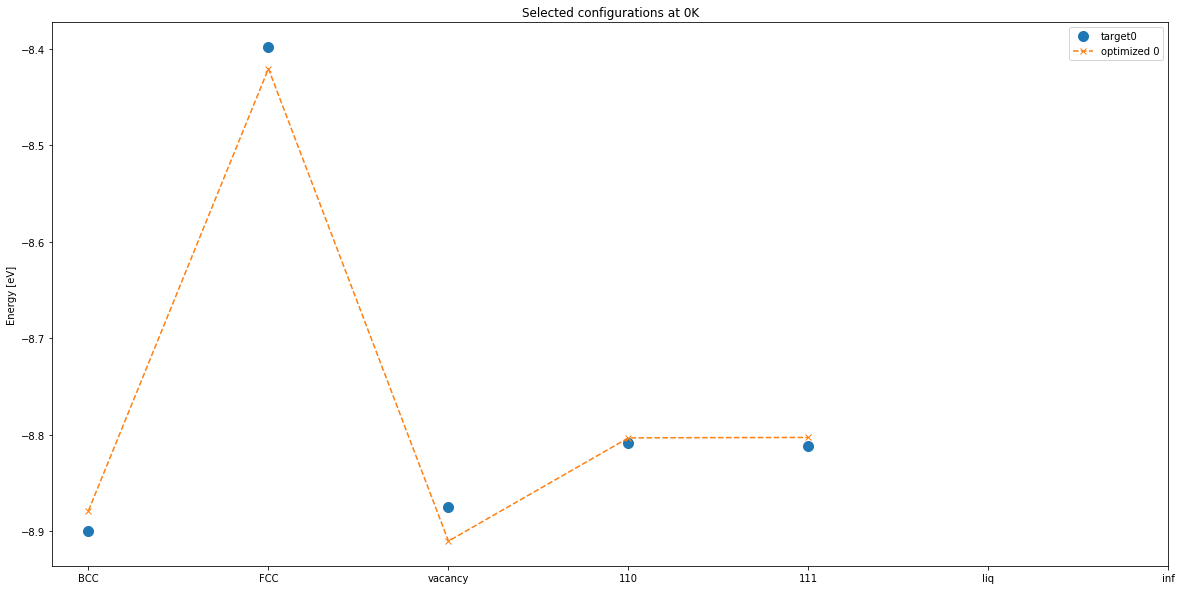

In [60]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-4][:-2])
        print('Model:', opti_out[-4][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-4][:-2]))/nat)
        plt.plot(np.array(targ_out[-4][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    print('Model:', opti_out[-4][:-2])

    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-4][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

8
Targ: [-1139.1553999999999, -1022.8066999999999, -1114.8183999999999, -1123.9361, -1084.6381, -1031.6408, -971.3192999999999, -907.6867, 0.0]
Model: [-1136.489148910112, -1008.6308653769183, -1112.6015965024726, -1102.8242656256098, -1058.7286377537807, -1015.1732098435778, -968.0762428548824, -915.260399365332, 0.0]
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0 0.011166762673644966


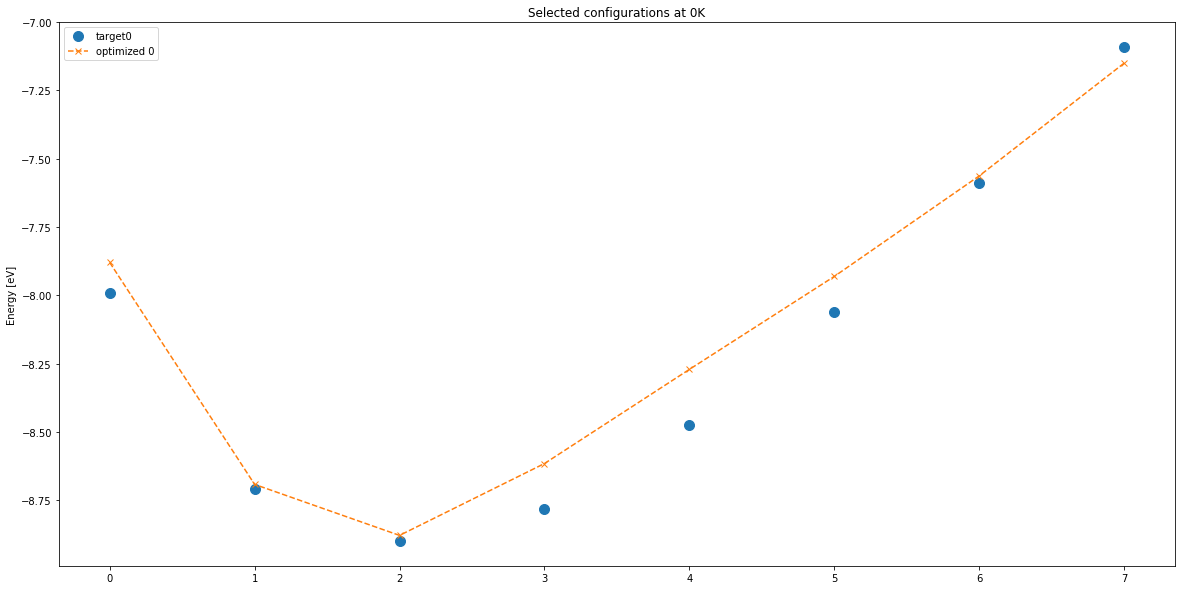

In [72]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos_bcc']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:])
        print('Model:', opti_out[-2][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-1]))/nat)
        plt.plot(np.array(targ_out[-2][:-1])[[1, 2, 0, 3, 4, 5, 6, 7]]/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-1]])[[1, 2, 0, 3, 4, 5, 6, 7]]/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

9
Targ: [-1139.2, -271.80472210708876, -837.1711089986525, -800.663344463534, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.40328537746313, -378.657941519064, 0.0]
Model: [-1136.489148910112, -256.54218465212216, -824.1402531510603, -787.3528760770478, -668.4695793280093, -562.762601770932, -479.231957497836, -417.8300073372641, -377.89732492613916, 0.0]
[0.0703125 0.0703125 0.0703125 0.0703125 0.0703125 0.0703125 0.0703125
 0.0703125 0.0703125]
0 0.011166762673644966


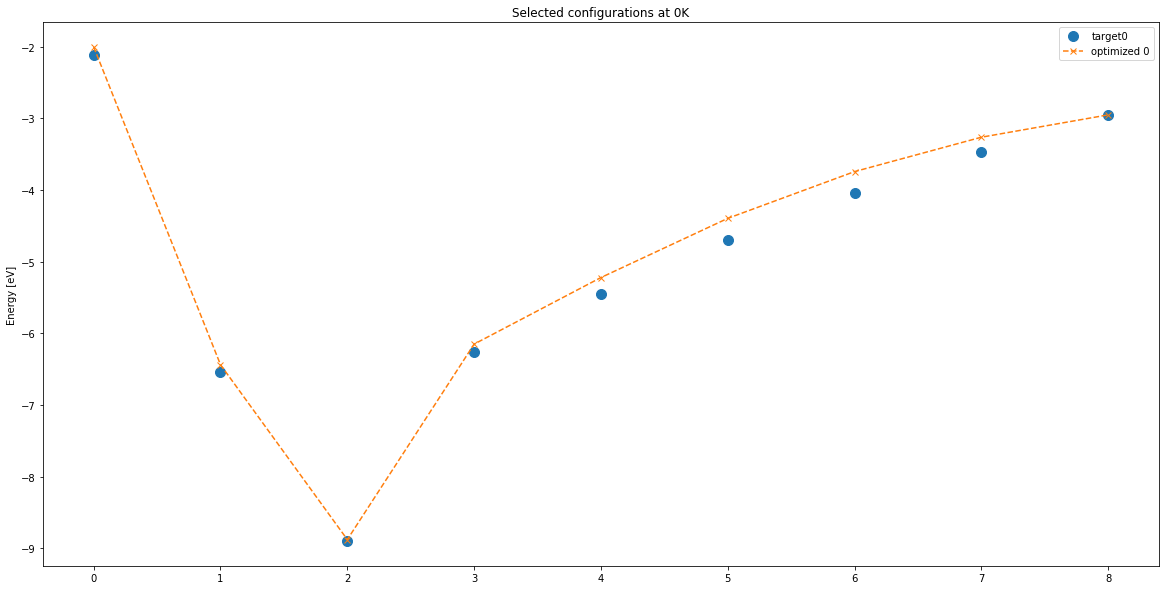

In [73]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-3][:])
        print('Model:', opti_out[-3][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-3][:-1]))/nat)
        plt.plot(np.array(targ_out[-3][:-1])[[1, 2, 0, 3, 4, 5, 6, 7, 8]]/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-3][:-1]])[[1, 2, 0, 3, 4, 5, 6, 7, 8]]/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

9
Targ: [-910.2984906249999, -910.2984906249999, -816.6878906249999, -890.3537906249999, -897.8806906249999, -865.893990625, -822.6411906249998, -773.407790625, -721.4408906249998, 0.0]
Model: [-909.254747791821, -909.254747791821, -840.1553605678655, -900.7635276643682, -897.7740661701891, -871.7433019659506, -834.9976027359298, -794.1508466977571, -753.8477097552209, 0.0]
[0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333]
0 0.011166762673644966


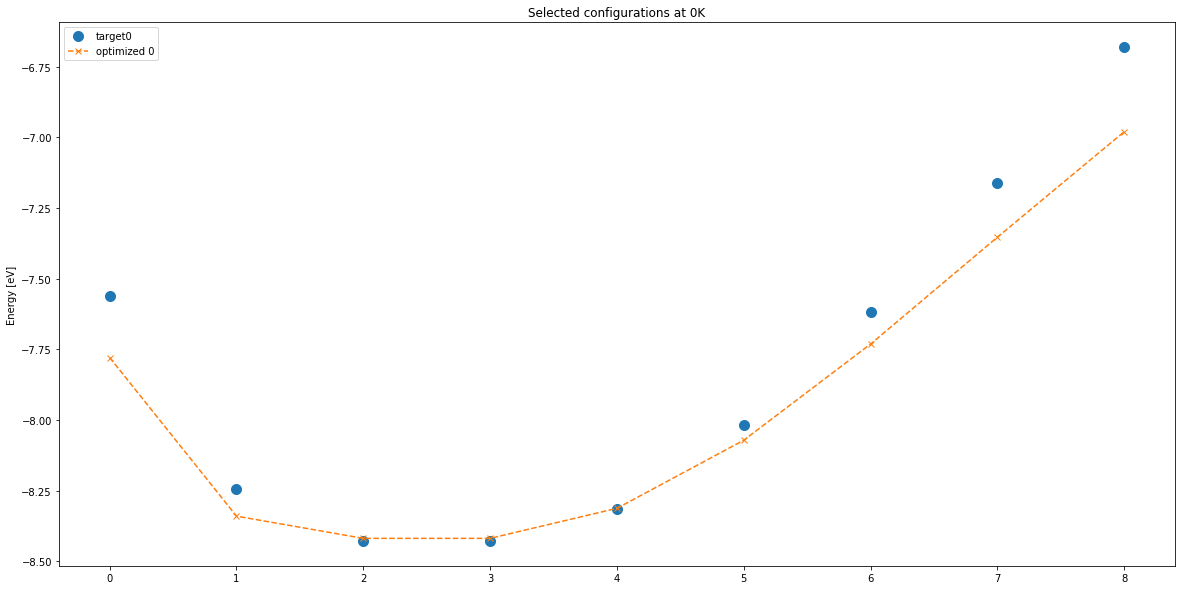

In [74]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos_fcc']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][:])
        print('Model:', opti_out[-1][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][:-1]))/nat)
        plt.plot(np.array(targ_out[-1][:-1])[[2, 3, 0, 1, 4, 5, 6, 7, 8]]/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot( np.array([o for o in opti_out[-1][:-1]])[[2, 3, 0, 1, 4, 5, 6, 7, 8]]/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

1284
[10.03125 10.03125 10.03125 ... 10.03125 10.03125 10.03125]
0 0.011166762673644966


ValueError: fname must be a PathLike or file handle

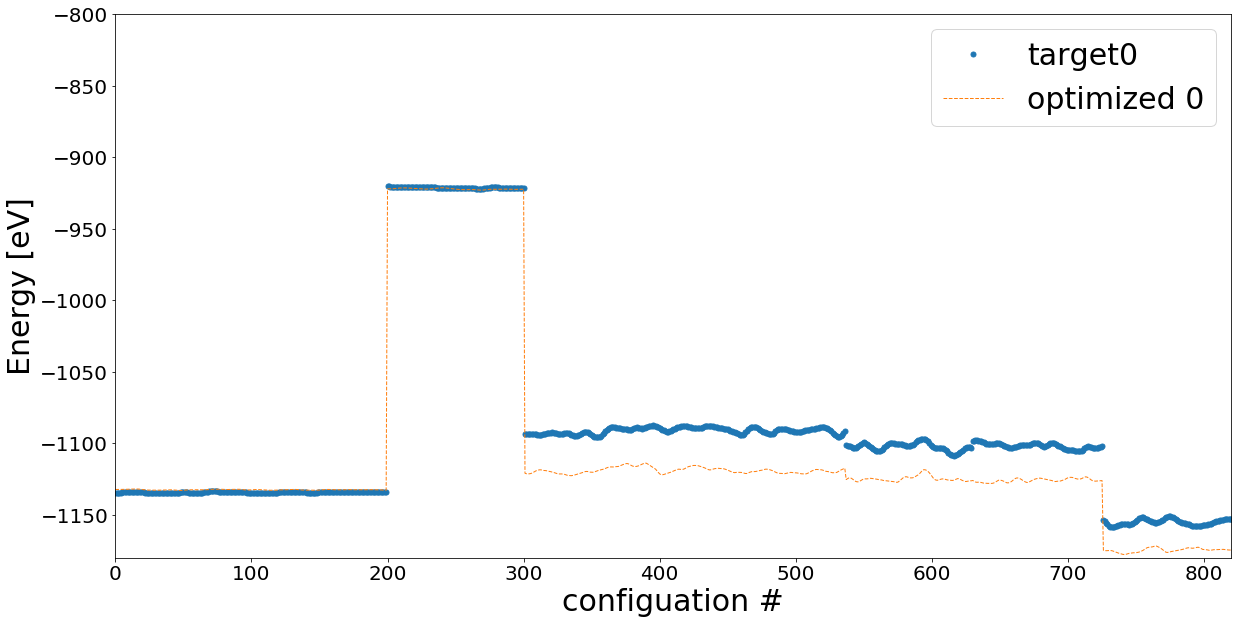

In [63]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[9])
    #plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=5)

        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 1:# and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]', fontsize=30)
plt.xlabel('configuation #', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

#plt.ylim(-1075,-1035)
#plt.ylim(-1000,-900)
#plt.ylim(-950,-900)
#plt.ylim(-1136,-1133)
plt.ylim(-1180,-800)
plt.xlim(0,820)
#plt.xlim(847,990)

#plt.ylim(-1180,-800)

plt.legend(fontsize=30)
plt.savefig(plt.savefig(os.path.join(working, 'bcc_300.png')))

In [ ]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

In [77]:
stats_opts[it]['hyperparams']

[2.5, 2.7, 2.75, 2.85, 3.0, 3.45, 4.0, 4.5, 5.0, 5.75]

In [78]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 9
pars_out['params'] = [optimal_parameters[0]]

In [79]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [80]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [81]:
optimal_list

[{'pair_nodes': [2.5, 2.7, 2.75, 2.85, 3.0, 3.45, 4.0, 4.5, 5.0, 5.75],
  'mb_node': 9,
  'params': [(0.011166762673644966,
    array([-1.43897524e+00,  3.68357996e-06, -4.10835857e+01,  1.01633094e+02,
           -9.73045925e+01,  3.38437384e+01, -3.58251075e+00, -1.67919252e+00,
            8.65702805e-01,  2.65888291e-01, -1.20777286e+00,  4.75855652e-01]))]}]

In [82]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [83]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [84]:
optimal_list[-1]['params'][0][1]

array([-1.43897524e+00,  3.68357996e-06, -4.10835857e+01,  1.01633094e+02,
       -9.73045925e+01,  3.38437384e+01, -3.58251075e+00, -1.67919252e+00,
        8.65702805e-01,  2.65888291e-01, -1.20777286e+00,  4.75855652e-01])

In [85]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [86]:
pair_y, many_y, V_x_r, rho_x_r

(array([-41.0835857 , 101.633094  , -97.3045925 ,  33.8437384 ,
         -3.58251075,  -1.67919252,   0.8657028 ,   0.26588829,
         -1.20777286,   0.47585565]),
 [-1.43897524, 0.0, 3.68357996e-06],
 [2.5, 2.7, 2.75, 2.85, 3.0, 3.45, 4.0, 4.5, 5.0, 5.75],
 [5.75])

In [87]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

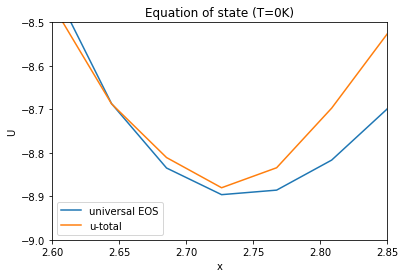

In [88]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.xlim(2.6, 2.85)
plt.ylim(-10,10)
plt.ylim(-9.,-8.5)

plt.xlabel('x')
plt.ylabel(r'U')

In [89]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [97]:
pair_y, many_y

(array([-41.0835857 , 101.633094  , -97.3045925 ,  33.8437384 ,
         -3.58251075,  -1.67919252,   0.8657028 ,   0.26588829,
         -1.20777286,   0.47585565]), [-1.43897524, 0.0, 3.68357996e-06])

In [100]:
print(V_x_r)
print((0.011166762673644966, np.array([-1.43897524e+00,  3.68357996e-06, -4.10835857e+01,  1.01633094e+02,
       -9.73045925e+01,  3.38437384e+01, -3.58251075e+00, -1.67919252e+00,
        8.65702805e-01,  2.65888291e-01, -1.20777286e+00,  4.75855652e-01])))

0.011166762673644966
(0.011166762673644966, array([-1.43897524e+00,  3.68357996e-06, -4.10835857e+01,  1.01633094e+02,
       -9.73045925e+01,  3.38437384e+01, -3.58251075e+00, -1.67919252e+00,
        8.65702805e-01,  2.65888291e-01, -1.20777286e+00,  4.75855652e-01]))


In [91]:
pair_a = optimal_list[-1]['params'][0][1][2:]#pars_in1[2:]
pair_r = optimal_list[-1]['pair_nodes']

rho_a = [1.0]
rho_r = [pair_r[optimal_list[-1]['mb_node']]]

par = optimal_list[-1]['params'][0][1][:2]
many_a = [par[0], 0.0, par[1]]

In [105]:
pair_a, pair_r, rho_r, many_a, par

(array([-41.0835857 , 101.633094  , -97.3045925 ,  33.8437384 ,
         -3.58251075,  -1.67919252,   0.8657028 ,   0.26588829,
         -1.20777286,   0.47585565]),
 [2.5, 2.7, 2.75, 2.85, 3.0, 3.45, 4.0, 4.5, 5.0, 5.75],
 [5.75],
 [-1.43897524, 0.0, 3.68357996e-06],
 array([-1.43897524e+00,  3.68357996e-06]))

In [92]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 921.1875


In [93]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [94]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [95]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lv_bccfcc.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))